# Notebook to Analyze Beam Profiles

In [2]:
import numpy as np
import numpy.random as rand
from scipy.constants import codata
import scipy.interpolate as si
from todloop.utils.pixels import PixelReader
from todloop.base import Routine, TODLoop
import cPickle
import os
import pprint
from todloop.utils.cuts import pixels_affected_in_event
from plot_glitches.routines import PlotGlitches
import moby2
from moby2.scripting import get_filebase
from random import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/mnt/act3/users/jpm136/miniconda2/lib/python2.7/site-packages/moby2/util/noninteractive_plots.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'TkAgg' by the following code:
  File "/mnt/act3/users/jpm136/miniconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/mnt/act3/users/jpm136/miniconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/mnt/act3/users/jpm136/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/mnt/act3/users/jpm136/miniconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/mnt/act3/users/jpm136/miniconda2/lib/python2.

## Import Relevant TOD Data

In [3]:
"""
#---------------------------------------------------------#
# Change tod variable to track you want to analyze below! #
#---------------------------------------------------------#
"""

tod = 10000
input_dir="../outputs/s16_pa3_list/cosig/"
postfix = "pickle"
filepath = "%s%s.%s" % (input_dir, tod, postfix)
if os.path.isfile(filepath):
    with open(filepath, "r") as f:
        cuts = cPickle.load(f)
else:
    print 'Cosig data NOT loaded!'

fb = get_filebase()
loop = TODLoop()
loop.add_tod_list("../data/s16_pa3_list.txt")
loop.run(tod,tod+1)
tod_name = loop.get_name()
tod_filename = fb.filename_from_name(tod_name, single=True)  # get file path
tod_data = moby2.scripting.get_tod({'filename': tod_filename, 'repair_pointing': True})
amdata = moby2.scripting.get_array_data({'season' : '2016','array_name': 'AR3'})
sky_x = amdata['sky_x']
sky_y = amdata['sky_y']

#fix optical sign
optical_signs = tod_data.info.array_data['optical_sign']
tod_data.data = tod_data.data*optical_signs[:, np.newaxis]

#calibrate
cal = moby2.scripting.get_calibration({'type': 'iv', 'source': 'data'}, tod=tod_data)
cal_mask, cal_val = cal.get_property('cal', det_uid=tod_data.det_uid)
tod_data.data *= cal_val[:,None]
    

## Load Beam Profile for Array 3, 90 GHz 
After loading the profile, set the variables `pa3_90x` and `pa3_90y` to columns of beam profile text file so that they can be interpolated as a function. 
<br>
For example, if you want to know what the value of the profile is at a certain angular separation $x$ , you can call this function `beam_profile(x)` to return its $y$-value.

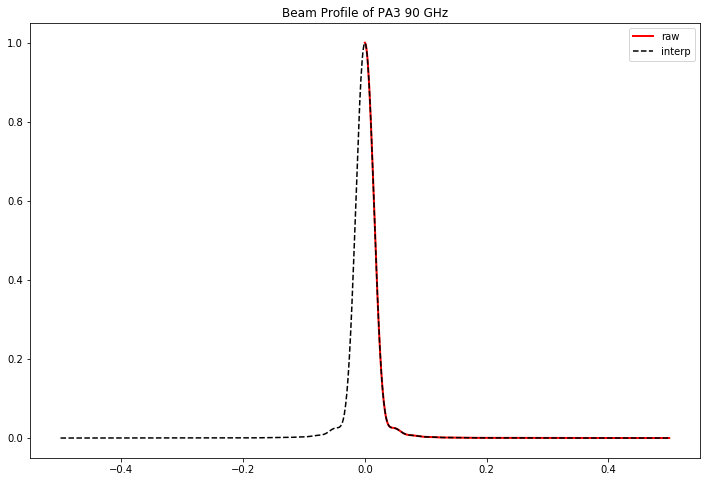

In [4]:
Beam_PA3_90 = np.loadtxt('beam_profile_170112_2015_pa3_90GHz_instant.txt', unpack=True, delimiter='  ', skiprows=4)

pa3_90x = Beam_PA3_90[0]
pa3_90y = Beam_PA3_90[1]
x = np.linspace(-0.5,0.5,1000)
beam_profile = si.interp1d(pa3_90x,pa3_90y,bounds_error=False,fill_value=0)

plt.figure(figsize=(12,8))
plt.title('Beam Profile of PA3 90 GHz')
plt.plot(pa3_90x,pa3_90y,'r',lw=2,label="raw")
plt.plot(x,beam_profile(np.abs(x)),'k--',label="interp")
plt.legend()
plt.show()


## Functions to Compute Brightness Temperature, Noise Levels, and Solid Angles
These functions will be called upon later when calculating the effective temperature and FRB flux density. 
<br>
<br>
`Solid_Angle_MC` is a function that takes the integration methods of `Solid_Angle` and uses a Monte Carlo method of integration to more accurately define the random nature of FRB signals. 

In [6]:
def Brightness_Temperature(Signal, Freq, Omega):
    """
    #------------------------------------------------#
    # Description: Computes the Brightness T in      #
    #              Kelvin for an FRB signal seen in  #
    #              the Atacama Cosmology Telescope.  #
    #                                                #
    # Parameters:                                    #
    #             Signal  : Signal Strength (Jy);    #
    #               Freq  : Frequency (GHz);         #
    #              Omega  : Solid Angle (sr);        #
    #------------------------------------------------#
    
    """
    
    # Boltzmann Constant:
    k_B = codata.value('Boltzmann constant')
    
    # Computes the radiation Wavelength (in meters):
    Lambda = 3e8/(Freq*1e9)
    
    # Jansky to J/m² Convertion:
    Jy_to_Jpm2 = 1e-26
    
    return ((Lambda**2)*Signal*Jy_to_Jpm2)/(2*k_B*Omega)


def Detector_Noise(Duration):
    """
    #------------------------------------------------#
    # Description: Computes the detector noise level #
    #              for a signal of given duration.   #
    #                                                #
    # Parameters:                                    #
    #             Duration  : Signal duration (ms);  #
    #------------------------------------------------#
    
    """
    
    # Average Detector Noise (in K√s):
    Av_Det_Noise = 400e-6
    
    # Computes the Noise Level:
    Noise_Level = Av_Det_Noise/np.sqrt(Duration/1000.)
    
    return Noise_Level

    
def Solid_Angle(Pol_Int, Az_Int, Beam):
    """
    #------------------------------------------------#
    # Description: Computes the instrument's beam    #
    #              solid angle integral for a given  #
    #              range of angles in spherical      #
    #              coordinates. 'Pol_Int' as well as #
    #              'Az_Int' must be a lists with two #
    #              elements each, determining the    #
    #              initial and final angles of       #
    #              integration for those variables.  #
    #              The 'Beam' must be an array of    #
    #              dimension 2 encapsulating the     #
    #              beam profile.                     #
    #                                                #
    # Parameters:                                    #
    #             Pol_Int  : Polar Angles (degrees); #
    #              Az_Int  : Azimuthal Angles (rad); #
    #                Beam  : Beam Profile;           #
    #------------------------------------------------#
    
    """
    
    # Converts the Beam Range to Radians:
    Range = Beam[0]*np.pi/180.
    
    # Computes the Azimuthal Integral:
    Phi_Partial = np.abs(Az_Int[1] - Az_Int[0])
    
    # Constructs a Filter Imposing the Polar Integration Limits:
    Filter = np.logical_and(Beam[0] > Pol_Int[0], Beam[0] < Pol_Int[1])
    
    # Computes the Polar Integration:
    Theta_Partial = np.trapz(Beam[1][Filter]*np.sin(Range[Filter]), Range[Filter])
    
    return Phi_Partial*Theta_Partial


def Solid_Angle_MC(Pol_Int, Az_Int, Beam):
    
    # Converts the Beam Range to Radians:
    Range = Beam[0]*np.pi/180.
    
    # Computes the Azimuthal Integral:
    Phi_Partial = np.abs(Az_Int[1] - Az_Int[0])
    
    # Constructs a Filter Imposing the Polar Integration Limits:
    Filter = np.logical_and(Beam[0] > Pol_Int[0], Beam[0] < Pol_Int[1])
    
    y = Beam[1][Filter]*np.sin(Range[Filter])
    x = Range[Filter]
    
    #Polar Integrand Function
    theta_f = si.interp1d(x,y)
    
    #For precision, increase this number
    nrectangles = 1000

    # Integration domain
    xlow = min(Range[Filter])
    xhigh = max(Range[Filter])

    # randomly distributed mid-points of each int area
    xvalues = xlow + (xhigh-xlow)*np.random.random(nrectangles) #x-value for each int area
    fvalues = theta_f(xvalues) # f(x_i) ==> y-value for each int area
    areas = fvalues * (xhigh-xlow)/nrectangles # Area (x*y)
    
    #Polar integral is sum of areas
    theta_integral = sum(areas)
   
    return theta_integral*Phi_Partial
    
  



### Check to see if Monte Carlo method is working as expected...

In [7]:
print 'PA3 (90 GHz):'
omega_tot = Solid_Angle([0, 0.9/2.], [0, np.pi*2.], Beam_PA3_90)
omega_tot_mc = Solid_Angle_MC([0, 0.9/2.], [0, np.pi*2.], Beam_PA3_90)
omega_part = Solid_Angle([0.00, 0.055/2.], [0, 2*np.pi], Beam_PA3_90)
omega_part_mc = Solid_Angle_MC([0.00, 0.055/2.], [0, 2*np.pi], Beam_PA3_90)
omega_ratio = omega_part/omega_tot
omega_ratio_mc = omega_part_mc/omega_tot_mc
print 'Non Monte-Carlo Omega Ratio:', omega_ratio
print 'Monte-Carlo Omega Ratio:', omega_ratio_mc
print 'Total Solid Angle:', Solid_Angle([0, 0.9/2.], [0, 2*np.pi], Beam_PA3_90), 'sr'




a = 0.055
print 'Ratio of beam profile at angular separation of', a, '=', beam_profile(a)

PA3 (90 GHz):
Non Monte-Carlo Omega Ratio: 0.636731603120909
Monte-Carlo Omega Ratio: 0.621757306686795
Total Solid Angle: 5.181628445594052e-07 sr
Ratio of beam profile at angular separation of 0.055 = 0.020870223246878


## Now Apply These Functions to Data 

First, initialize the plot for the detector array and change `event` to some highly likely FRB event from `cor_analysis.py` for this TOD track. Collect the pixels affected in this event under `pixels`. The function `plot_pixels` is similar to `pr.plot()`, but instead of calling on `array_x` and `array_y`, it will call on `sky_x` and `sky_y`. Use this call instead of `pr.plot()` to keep all units in terms of degrees when studying the beam profile.
<br>
<br>
The next block of code will list the pixels affected in the event, their xy-coordinates gathered from `sky_x` and `sky_y` and then, it will plot the Temperature of the Signal ($K$) as a function of the FRB Flux Density in $Jy$ (in terms of Brightness Temperature and Solid Angle Ratio). The dotted line signifies the noise level the signal must be above for us to be able to detect it as an FRB. 
<br>
<br>
Running the second block of code multiple times, you will find that the graph displayed is not the same, because the solid angle produced by the random FRB signal changes every time. `l` can be set to a distance from the center of the detector defining the radius of the solid angle you are interested in, and while this distance remains the same in all runs (unless explicitly changed), the solid angle changes adhering to the randomized nature of the Monte Carlo method. 

In [9]:
pr = PixelReader()
pg = PlotGlitches(tod_key="tod_data", cosig_key="cuts")
cs = cuts['coincident_signals']
#event = [203586, 203591, 5, 3] 
#event = [217833, 217837, 4, 4]
event = [163370, 163373, 3, 2]
stime = event[0]
etime = event[1]
pixels = pixels_affected_in_event(cs,event)

[593, 721]
XY Coordinates of Pixels in Degrees:
Distance of signal 1/ 2.0


593 : -0.17238157027078363 0.5600199504716703
Omega Ratio: 0.6402505324389908


721 : -0.17278345003427378 0.5058157450492972
Omega Ratio: 0.6709669120093708




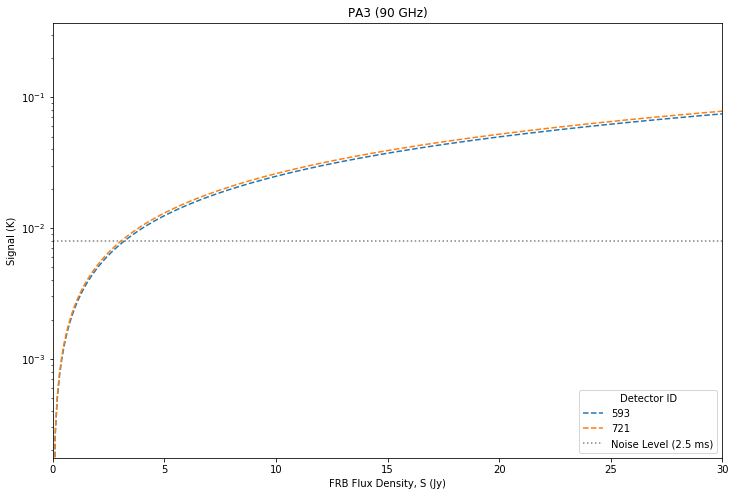

In [10]:
# Signal Range in Jansky:
Signal_Range = np.linspace(0, 100, 1000)

# Duration Range in Milliseconds:
Duration_Range = np.linspace(1, 10, 5)

plt.figure(figsize=(12,8))

print pixels
print 'XY Coordinates of Pixels in Degrees:'

distance = [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]
#l = random.choice(distance)
l = 2.
print 'Distance of signal 1/', l
print '\n'
for i,j in enumerate(pixels):
    x = sky_x[pixels[i]]
    y = sky_y[pixels[i]]
    z = .055 #dist between adjacent detectors
    omega_tot = Solid_Angle_MC([0, 0.9/l], [0, 2*np.pi], Beam_PA3_90)
    omega_part = Solid_Angle_MC([0.00, z/l], [0, 2*np.pi], Beam_PA3_90)
    omega_ratio = omega_part/omega_tot
    plt.plot(Signal_Range, Brightness_Temperature(Signal_Range, 90, 5.18162844559e-07)*omega_ratio/2.,'--', label=str(j))
    print j, ':', x, y
    print 'Omega Ratio:', omega_ratio
    print '\n'

plt.hlines(Detector_Noise(2.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dotted', label='Noise Level (2.5 ms)')    
#plt.hlines(Detector_Noise(7.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dashed', label='T = 7.5 ms')
#plt.hlines(Detector_Noise(15), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='solid', label='T = 15 ms')

plt.yscale('log')
plt.xlim([0, 30])

plt.xlabel('FRB Flux Density, S (Jy)')
plt.ylabel('Signal (K)')

plt.title ('PA3 (90 GHz)')
plt.legend(title='Detector ID',loc=4)
plt.show()

### Define a `timeseries` function to return the time profile of an FRB candidate
This function is set to return the timeseries for 90GHz data from an event.
<br>
Currently, it is not being used to plot anything, but it may be useful later if you need to see the time profile and verify that the glitch is correctly classified as an FRB candidate
<br>
<br>
The next block of code, redefines functions from the original `todloop.utils` to retrieve pixel data from `sky_x` and `sky_y`, so that all values are in terms of degrees. 


In [11]:
def timeseries(pixel_id, s_time, e_time, buffer=10):
    start_time = s_time - buffer
    end_time = e_time + buffer
    a1, a2 = pr.get_f1(pixel_id)
    d1, d2 = tod_data.data[a1], tod_data.data[a2]
    # try to remove the mean from start_time to end_time                                                                                                     
    d1 -= np.mean(d1[start_time:end_time])

    time = tod_data.ctime - tod_data.ctime[0]
    time = time[start_time:end_time]

    d_1 = d1[start_time:end_time]

    return time, d_1

In [12]:
def plot_pixels(pixels=None):
    x,y = np.asarray(pr._array_data['sky_x']),np.asarray(pr._array_data['sky_y'])
    plt.plot(x, y, 'r.')
    #plt.grid(c='k',linestyle='--')
    if pixels:
        x1,y1 = np.asarray(pr._array_data['sky_x'][pixels]),np.asarray(pr._array_data['sky_y'][pixels])
        plt.plot(x1,y1,'b.', markersize = 20, alpha = 0.5)

def get_pixels_within_radius(xy_list, radius):
    """
    xy_list:
    give single xy positions as list of xc and yc of beam profile
    [xc,yc]
    """
    pr._array_pos = np.vstack([pr._array_data['sky_x'], pr._array_data['sky_y']]).T
    ar = pr._array_pos
    dist = np.sqrt(np.sum((ar - xy_list)**2, axis=1))
    return [det for det in np.arange(1056)[dist < radius] if str(det) in pr._pixel_dict]

def get_x_y(pixel):
    return pr._array_data['sky_x'][pixel], pr._array_data['sky_y'][pixel]


<a id='Random Location Generator'></a>

## Randomly Generate a Location for an FRB Event to Take Place on the Detector Array

This next block of code will plot the detector array (in red), the pixels affected in the event (in blue), if you specify `plot_pixels(pixels)`, and a randomly generated location for an FRB event to take place (in green). 
<br>

The block of code after that will visualize the generated signal affecting the detector on the $xyz$-plane. 
This will be later used to understand how detectors at different distances from the event detect the event and what is the threshold distance for detecting an FRB event.

Center of Generated Signal, xy: -0.0112166122035 0.722310359729


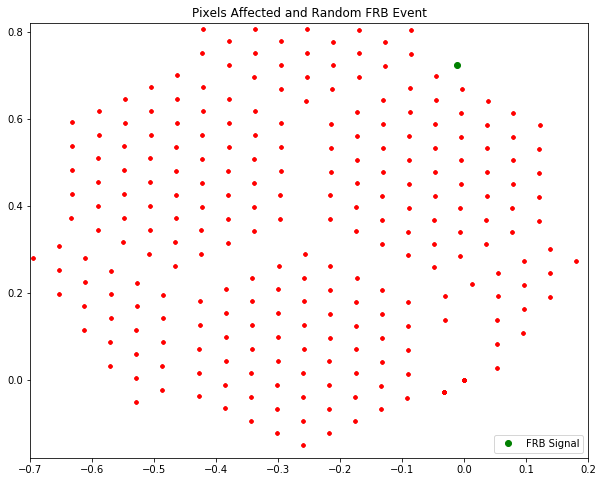

In [51]:
plt.figure(figsize=(10,8))

# xc and yc are the center of the randomly generated signal 
xc,yc = np.random.uniform(-0.7,0.2),np.random.uniform(-0.18,0.82)
print 'Center of Generated Signal, xy:', xc, yc
plot_pixels()
plt.plot(xc,yc,'go',label="FRB Signal")
plt.title('Pixels Affected and Random FRB Event')
plt.xlim(-0.7,0.2)
plt.ylim(-0.18,0.82)
plt.legend(loc=4)
plt.show()

## Functions for 2D plotting on 3D Axes

The following two functions are not relevant for our data analysis, but they are defined so that we can plot circles to define the radius within which we are collecting the flux. 
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

In [52]:
def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M
def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix
    
    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

## 3D Plots of Beam Profile

The next block of code will let us visualize an FRB (point source) hitting the detector array in 3D. The location of the beam is determined by the randomly generated `xc` and `yc` coordinates defined earlier. 
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

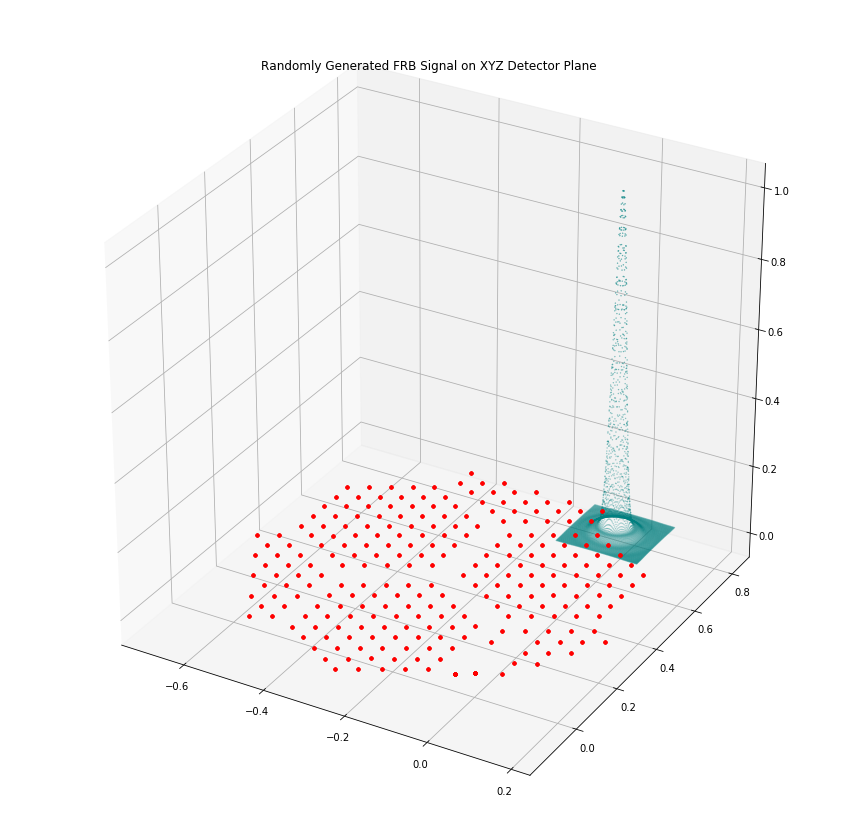

In [53]:
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import mpl_toolkits.mplot3d.art3d as art3d

"""
For Reference:
pa3_90x = Beam_PA3_90[0]
pa3_90y = Beam_PA3_90[1]
x = np.linspace(min(pa3_90x),max(pa3_90x),1000)
beam_profile = si.interp1d(pa3_90x,pa3_90y)
"""

x_new = np.linspace(xc-.1,xc+.1,100)
y_new = np.linspace(yc-.1,yc+.1,100)
#plt.plot(x_new,y_new)
xz,yz = np.meshgrid(x_new,y_new)
minx,maxx = np.min(xz),np.max(xz)
miny,maxy = np.min(yz),np.max(yz)

#subtract off the center point to displace the distribution
r = np.sqrt((xz-xc)**2 + (yz-yc)**2)
z = beam_profile(r)


plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
plot_pixels()
plt.title('Randomly Generated FRB Signal on XYZ Detector Plane')
ax.scatter(xz, yz, z, c='teal',depthshade=True, s=.1)
#plt.savefig('Random_beam_on_detector.png')
plt.show()


## Integrate the Beam

No longer relevant for our analysis, but if needed, the following function will determine the area under the beam using a Monte Carlo method of integration.
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

In [54]:
def MonteCarlo_double(f, g, x_olim, y_olim, x_lim, y_lim, n):
    """
    #-------------------------------------------------#
    # Description:                                    #
    # Monte Carlo integration of f over a domain g>=0,#
    # n^2 is the number of random points.             #
    #                                                 #
    # Parameters:                                     #
    # f: integrand function                           #
    # g: function that decides which points are       #
    #    within bounds                                #
    # x_olim, y_olim: lists of overshot bounds of     #
    #                 integration                     #
    # x_lim, y_lim: lists of actual bounds of         #
    #               integration                       #
    # n: number of points to define intgration grid   #
    #-------------------------------------------------#
    """
    #Unpack Variables
    x0,x1 = x_olim[0],x_olim[1]
    y0,y1 = y_olim[0],y_olim[1]
    x_0,x_1 = x_lim[0],x_lim[1]
    y_0,y_1 = y_lim[0],y_lim[1]
    
    # Draw n**2 random points in the area of integration  
    x = np.random.uniform(x0, x1, n)
    y = np.random.uniform(y0, y1, n)
    
    # Compute sum of f values inside the integration domain
    f_mean = 0
    num_inside = 0   # number of x,y points inside domain (g>=0)
    for i in range(len(x)):
        for j in range(len(y)):
            if g(x[i], y[j],x_lim,y_lim) >= 0:
                num_inside += 1
                f_mean += f(x[i], y[j])
    f_mean = f_mean/float(num_inside)
    area = num_inside/float(n**2)*(x1 - x0)*(y1 - y0)
    return area*f_mean

def g(x, y,x_lim,y_lim):
    
    """
    x_lim: list of starting and ending bounds of x-integration
    y_lim: list of starting and ending bounds of y-integration
    """
    x0,x1 = x_lim[0],x_lim[1]
    y0,y1 = y_lim[0],y_lim[1]
    return(1 if (x0 <= x <= x1 and y0 <= y <= y1) else -1)
    
(MonteCarlo_double(lambda xz,yz: beam_profile(np.sqrt((xz-xc)**2 + (yz-yc)**2)),g, [minx-0.5,maxx+0.5],[miny-0.5,maxy+0.5],[minx,maxx],[miny,maxy],100))



0.001876227020512666

## Zoom in on the Beam

Zoom in on the beam hitting the area to get a better understanding of the pixels affected around the event. 
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

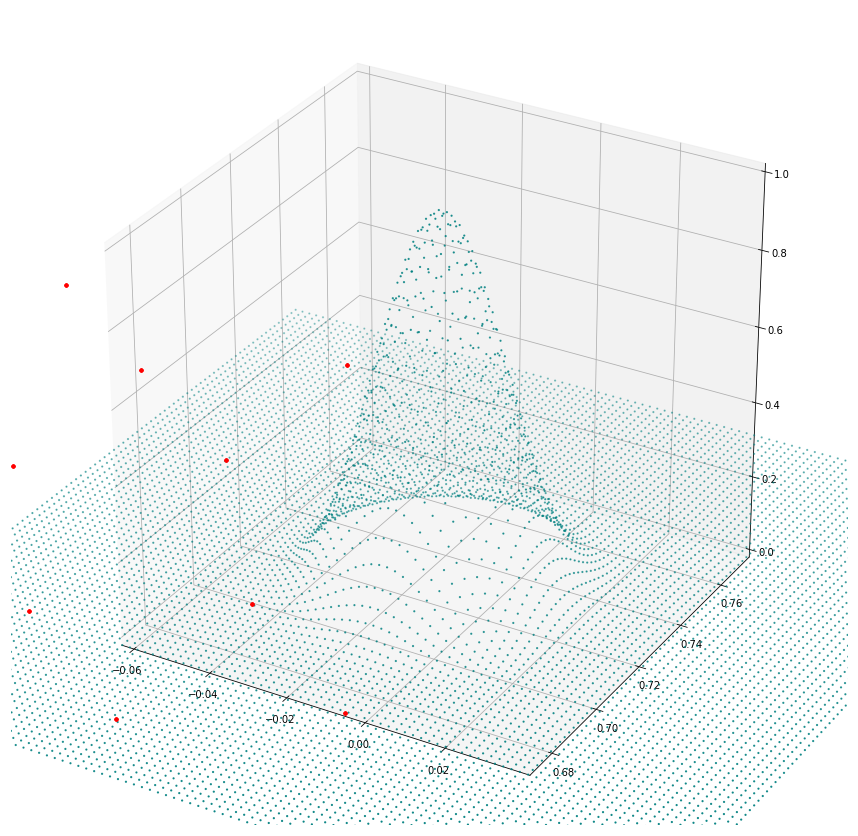

In [55]:
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(xz, yz,z, c='teal',depthshade=True, s=1.5)
plot_pixels()
ax.set_xlim(xc-.05, xc+.05); ax.set_ylim(yc-.05, yc+.05); ax.set_zlim(0, 1);
plt.show()

## Use a Monte Carlo Method of Throwing Points 
The following function will throw points at the detector using the probability distribution defined by the beam profile. 
*Written by Yilun!
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

In [56]:
def gen_mc_xy(x_ctr, y_ctr, size):
    """A function that generates random points based on the beam profile
    :param:
        x_ctr: x coord of the center of frb
        y_ctr: y coord of the center of frb
        size: number of points to be generated
    :ret: 
        x_rnd: x coords of generated points
        y_rnd: y coords of generated points
    """
    # Generate radius and the corresponding probs
    r = np.linspace(0, 1, size)  # radius
    p = beam_profile(r)  # probs

    # Normalize probs
    p = p / p.sum()

    # Generate random radius
    r_rnd = np.random.choice(r, size=size, p=p)

    # Generate random polar angles
    theta_rnd = np.random.rand(size) * 2 * np.pi  # this generate uniform random number between 0 to 2 Pi

    # Convert to x, y coords
    x_rnd = x_ctr + r_rnd * np.cos(theta_rnd)
    y_rnd = y_ctr + r_rnd * np.sin(theta_rnd)
    
    return x_rnd, y_rnd

## Plot the Points Falling into a Feedhorn

Define a radius around each feedhorn, and calculate the percentage of the points falling into each feedhorn to get an understanding of the flux received in each detector at a given distance from the event. 
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

Pixel: 337 
 Collected: 9 / 1000 of the photons, 
 Distance: 0.05414719334155334 degrees from beam 
 Flux percentage: 0.009
Pixel: 592 
 Collected: 44 / 1000 of the photons, 
 Distance: 0.04274225832668408 degrees from beam 
 Flux percentage: 0.044
Pixel: 922 
 Collected: 2 / 1000 of the photons, 
 Distance: 0.0789552224383385 degrees from beam 
 Flux percentage: 0.002


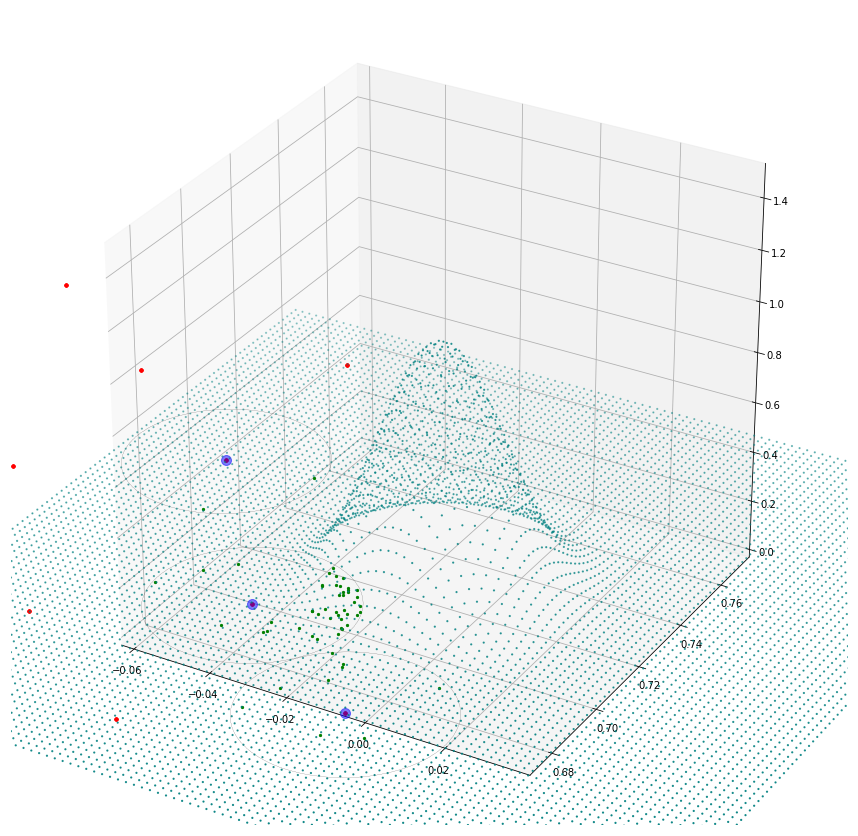

In [57]:
# Plot zoomed in detector array and beam
plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.scatter(xz, yz, z, c='teal',depthshade=True, s=1.5)
ax.set_xlim(xc-.05, xc+.05); ax.set_ylim(yc-.05, yc+.05); ax.set_zlim(0, 1.5);

#Get all the pixels within a certain radius of the event
pix = get_pixels_within_radius([xc,yc],.08)
plot_pixels(pix)

#the number of points that will be thrown
size = 1000

def calculate_ratios(xc,yc,pix_list,size,print_=True):
    """
    parameters: xc,yc - xcenter, ycenter of beam
                pix_list - list of pixels near to the beam
                size - how many times you ran the monte carlo method
    return: The flux ratio
    """
    x, y = gen_mc_xy(xc, yc, size)
    rad = .025
    flux = []
    distance = []
    for p in pix_list:
        included = []
        x0,y0 = get_x_y(p)
        circle = Circle((x0, y0), rad,ec='k',fill=False,ls='--',lw=.2)
        ax.add_patch(circle)
        pathpatch_2d_to_3d(circle, z=0, normal='z')
        for i,j in zip(x,y):
            r = np.sqrt((i-x0)**2 + (j - y0)**2)  
            if r<=rad:
                included.append(1)
                ax.scatter(i,j,c="g", s=5) 
        dist = np.sqrt((xc-x0)**2 + (yc-y0)**2)
        collected = float(len(included))
        fluxx = collected/float(size) 
        flux.append(fluxx)
        distance.append(dist)
        if print_ == True:
            print 'Pixel:',p,'\n Collected:', len(included), '/' ,size , 'of the photons, \n Distance:', dist, 'degrees from beam \n Flux percentage:', fluxx
    if print_ == False:
        return pix_list, flux, distance

calculate_ratios(xc,yc,pix,size)
#plt.savefig('Beam_bw_2_detectors_1.png')

## Signal to Noise Ratio Analysis
<br>
<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

### For Single Event...

Pixels: [337, 592, 922]
Fluxes: [0.007, 0.04, 0.001]
Distances: [0.05414719 0.04274226 0.07895522]
4.8


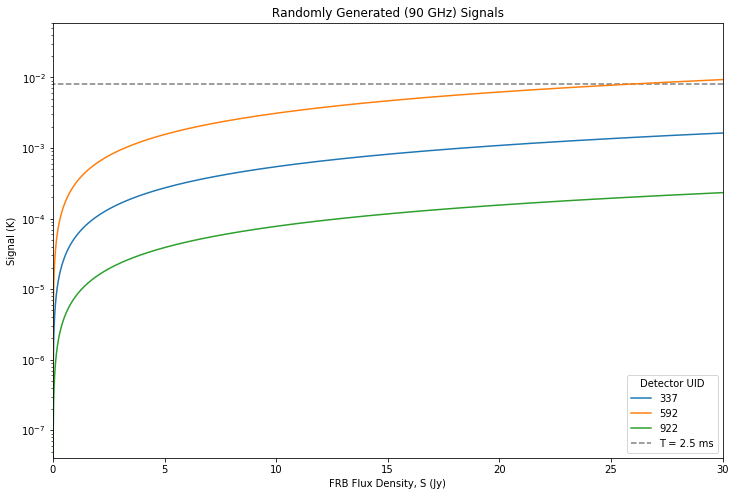

In [58]:
pix_list, fluxes, distance = calculate_ratios(xc,yc,pix,size,print_= False )
print 'Pixels:',pix_list
print 'Fluxes:',fluxes
dist = [float(i) for i in distance]
print 'Distances:', np.asarray(dist)
print sum(fluxes)*100
# Duration Range in Milliseconds:
Duration_Range = np.linspace(1, 10, 5)
plt.figure(figsize=(12,8))


for p,f in zip(pix_list,fluxes):
    # Signal Range in Jansky:
    Signal_Range = np.linspace(0, 100, 10000)
    plt.plot(Signal_Range, Brightness_Temperature(Signal_Range, 90, 5.18162844559e-07)*f,ls= '-',label=str(p))
    
plt.hlines(Detector_Noise(2.5), -0.5, 100, alpha=0.5, linestyle='--',label = 'T = 2.5 ms')
#plt.hlines(Detector_Noise(7.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dashed', label='T = 7.5 ms')
#plt.hlines(Detector_Noise(15), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='solid', label='T = 15 ms')

plt.yscale('log')
plt.xlim([0, 30])

plt.xlabel('FRB Flux Density, S (Jy)')
plt.ylabel('Signal (K)')

plt.title(' Randomly Generated (90 GHz) Signals ')
plt.legend(title='Detector UID',loc=4)
plt.show()
#plt.savefig('Beam_bw_2_signaltonoise_1.png')


### For Multiple Events...

<a href='#Random Location Generator' >Take me back to generate a new random location!'</a>

In [44]:
Detector_Noise(2.5)

0.008

In [48]:
plt.figure(figsize=(12,8))

ten_jy = []
i = 0
n = 50 #how many random events you want to run this loop for
while i <= n:
    x_c,y_c = np.random.uniform(-0.7,0.2),np.random.uniform(-0.18,0.82)
    size_ = 1000
    pix_ = get_pixels_within_radius([x_c,y_c],.08)
    p, flux_,distances = calculate_ratios(x_c,y_c,pix_,size_,print_= False )
    f = max(np.asarray(flux_))
    # Signal Range in Jansky:
    Signal_Range = np.linspace(0, 100, 1000)
    Flux_Ratio = Brightness_Temperature(Signal_Range, 90, 5.18162844559e-07)*f
    flux_func = si.interp1d(Signal_Range,Flux_Ratio)
    flux_10 = flux_func(10)
    ten_jy.append(flux_func(10))

    i+=1

#print ten_jy
plt.hist(ten_jy,bins=20)
plt.show()
#plt.ylim(-.001,.03)
#plt.show()          

ValueError: max() arg is an empty sequence

<Figure size 864x576 with 0 Axes>